# Read in Census and SD data
# Build dataframe of scaled features and scaled labels (i.e., median number of days businesses have been open in each tract)
## Add in some dummy variables for simplified NAICS code
## Add in some interaction terms

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
# define extra bit for filenames for codes w/ # businesses >3000 (equivalently >2100)
extras = ['54','81','45','62','56','44','72','53']
# add codes w/ # businesses <2100 & >500
#extras = [extras, ]'42','23','48','61','71','52','51','33']
# add codes w/ # businesses <500 & >50
#extras = [extras, '32','31','49','55','11']
# add codes w/ # businesses <50
#extras = [extras, '22','92','21']

# pick which code to look at
i = 7
extra = '_'+extras[i]

## Labels

In [4]:
# read in labels (i.e., business info)
bus = pd.read_csv('data_final/sd_active_businesses_cleaned.csv')
print len(bus)
print bus[:5]

# use only current business code
bus = bus[bus.naics_code_simple==float(extras[i])]
# drop tract 9902 (mostly SD Harbor, not much land) is always best tract, w/ only 3 quite old businesses (10-30 yr)
bus = bus[bus.census_tract != 9902]

print len(bus)
bus[:5]

56710
   account_key            doing_bus_as_name  days_since_creation  naics_code  \
0   2016008533          ARCHITECT ATHLETICS                   61       42199   
1   2016008531        SILVER LINING STAGERS                   61       54149   
2   2016008529                  TAMKEEN INC                   61       42299   
3   2016008525  REBECCA EICHTEN ART  DESIGN                   61       45311   
4   2016008524  COLD STONE CREAMERY   20837                   61       72221   

   naics_code_simple  census_tract  
0                 42          3212  
1                 54          8335  
2                 42          8511  
3                 45           900  
4                 72          7905  
3016


account_key                   doing_bus_as_name  days_since_creation  \
14    2016008503                   U-STOR-IT 805 LLC                   61   
44    2016008433                          STEVE RADA                   62   
48    2016008424                     S K INNOVATIONS                   62   
99    2016008290       CONSTRUCTION FENCE RENTAL INC                   68   
172   2016008104  SAFI CAR RENTAL INC DBA SAFI MOTOR                   71   

     naics_code  naics_code_simple  census_tract  
14        53113                 53          3404  
44        53139                 53          8511  
48         5313                 53          5200  
99          532                 53          6500  
172       53211                 53          9603

In [5]:
# get median days since creation for each tract
tracts_age = bus.groupby('census_tract').median().days_since_creation
tracts = tracts_age.index
median_days_open = tracts_age.values
print tracts
print median_days_open[0:10]
print len(tracts)

Int64Index([  100,   201,   202,   300,   400,   500,   600,   700,   800,
              900,
            ...
            17046, 17047, 17051, 17052, 17055, 17056, 17403, 21400, 21500,
            21800],
           dtype='int64', name=u'census_tract', length=249)
[ 1953.   3057.   3078.   3592.   1981.   1247.   3312.    993.5  2526.5
   860.5]
249


In [162]:
# plot histogram of median days since creation
plt.figure(figsize=(13, 10))
(tracts_age/365).hist(bins=19)
plt.xlabel('Median Age of Business in Years',fontsize=35)
plt.ylabel('# of Neighborhoods',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)

# print some stats of ages
print min(tracts_age/365)
print max(tracts_age/365)
#print min(median_days_open/365)
#print max(median_days_open/365)
print np.mean(tracts_age/365)
print np.median(tracts_age/365)
print np.std(tracts_age/365)

0.690410958904
23.3178082192
6.44326346482
5.77397260274
3.91775022123


[ 0.20595714  0.3396295   0.34217218  0.40440731  0.20934738  0.12047463
  0.3705049   0.08978085  0.27539654  0.0736772 ]
1.0
0.0
0.254242785405
0.224664002906
0.173141885307


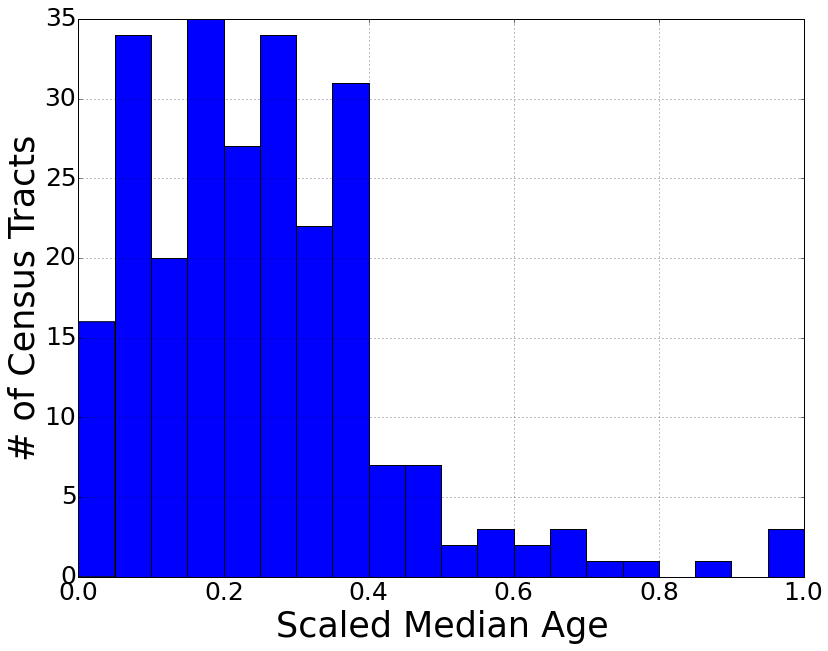

In [163]:
# scale labels to 0-1
median_days_open_scaled = (median_days_open-min(median_days_open)) / (max(median_days_open)-min(median_days_open))
print median_days_open_scaled[:10]
print max(median_days_open_scaled)
print min(median_days_open_scaled)

# plot new histogram
plt.figure(figsize=(13, 10))
plt.hist(median_days_open_scaled,bins=20)
plt.xlabel('Scaled Median Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.grid()

# print some stats of scaled ages
print np.mean(median_days_open_scaled)
print np.median(median_days_open_scaled)
print np.std(median_days_open_scaled)

## Features

In [164]:
# save total # of businesses in each tract
n_bus_all = bus.groupby('census_tract').count().account_key
print n_bus_all[:10]
print sum(n_bus_all)

census_tract
100    11
201     9
202     9
300    23
400    23
500     8
600     9
700    18
800     6
900    10
Name: account_key, dtype: int64
3016


In [165]:
print len(tracts)
print len(median_days_open_scaled)
print len(n_bus_all)

249
249
249


In [166]:
# combine feaures from business info into a dataframe
bus_features = pd.DataFrame({'bus_age': median_days_open_scaled, 'n_business': n_bus_all}, index=tracts)
bus_features[:5]

bus_age  n_business
census_tract                      
100           0.205957          11
201           0.339629           9
202           0.342172           9
300           0.404407          23
400           0.209347          23

In [167]:
# read in other features
popl = pd.read_csv('data_final/sd_population_cleaned.csv',index_col=0)
fin = pd.read_csv('data_final/sd_housing_employment_income_cleaned.csv',index_col=0)
bike = pd.read_csv('data_final/walk_transit_bike_cleaned.csv',index_col=0)
parking_meters = pd.read_csv('data_final/sd_parking_meters_cleaned.csv',index_col=0)

# choose which features to use (per census tract)
    # n_business (total number of businesses)
    # population (population)
    # population_percent_male
    # population_percent_female
    # age_med (median age)
    # age_med_male (median male age)
    # age_med_female (median female age)
    # minor_percent (percenage under 18)
    # adult_percent (percentage over 18)
    # homes (number of homes)
    # homes_percent_mortgage (percentage of homes owne w/ mortgage)
    # homes_percent_clear (percentage of homes owned free & clear)
    # homes_percent_rent (percentage of homes rented)
    # employment_percent (employment percentage)
    # income_med (median income)
    # income_med_owner (median income for owned homes)
    # income_med_renter (median income for rented homes)
    # cost_med (median housing cost)
    # cost_med_owner (median cost for owned homes)
    # cost_med_renter (median cost for rented homes)
    # walk_score
    # transit_score
    # bike_score
    # total_amount (parking meters)

In [168]:
popl[:5]

population  population_percent_male  population_percent_female  \
census_tract                                                                   
100                 3029                 0.501155                   0.498845   
201                 1801                 0.469184                   0.530816   
202                 4208                 0.506416                   0.493584   
300                 4732                 0.519865                   0.480135   
400                 3669                 0.549741                   0.450259   

              age_med  age_med_male  age_med_female  minor_percent  \
census_tract                                                         
100              50.3          49.8            50.8       0.181248   
201              46.5          45.5            48.1       0.131038   
202              39.6          40.0            38.8       0.115589   
300              38.8          40.9            35.8       0.050297   
400              35.5          38.2            32.7       0.047633   

              adult_percent  
census_tract                 
100                0.818752  
201                0.868962  
202                0.884411  
300                0.949703  
400                0.952367

In [169]:
bike[:10]

walk_score  transit_score  bike_score
census_tract                                       
1900                  72             46          50
9703                  38             27          30
9602                  38             27          30
8503                  40             29          37
8501                  40             29          37
9104                  46             31          39
9103                  46             31          39
9102                  46             31          39
9101                  46             31          39
3214                  34             35          25

4928.84235669
4629.0
2584.1009153


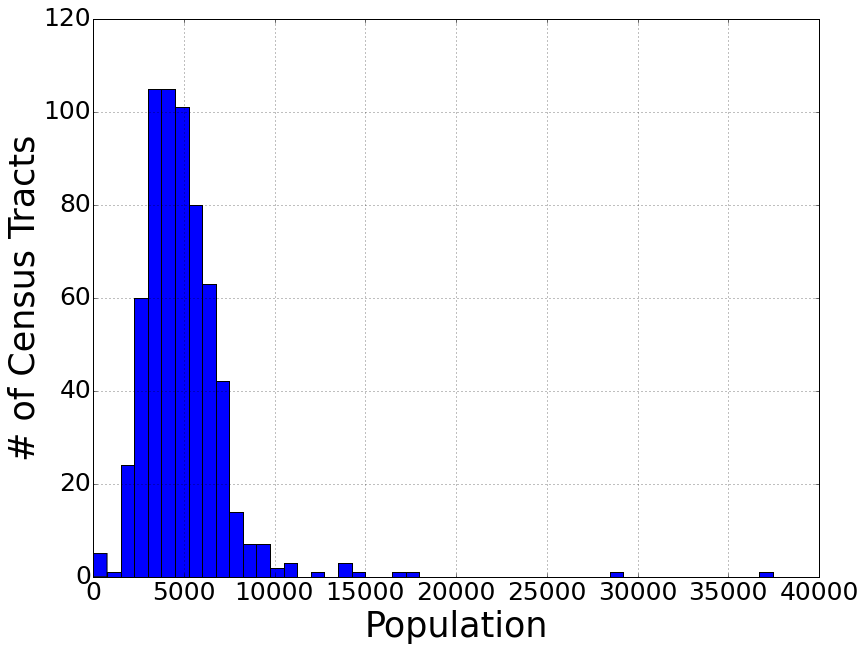

In [170]:
# plot histogram of population per census tract
plt.figure(figsize=(13, 10))
popl.population.hist(bins=50)
plt.xlabel('Population',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)
print np.mean(popl.population)
print np.median(popl.population)
print np.std(popl.population)

In [171]:
fin[:5]

homes  homes_percent_mortgage  homes_percent_clear  \
census_tract                                                       
100            1397                    58.9                 23.1   
201            1047                    34.1                 11.1   
202            2413                    32.7                  9.5   
300            3136                    21.5                  6.6   
400            2288                    12.2                  3.4   

              homes_percent_rent  employment_percent  income_med  \
census_tract                                                       
100                         18.0                54.6      106406   
201                         54.8                69.2       97976   
202                         57.8                75.0       75019   
300                         71.9                71.2       61679   
400                         84.4                75.4       68488   

              income_med_owner  income_med_renter  cost_med  cost_med_owner  \
census_tract                                                                  
100                     115066              27813      1895            1923   
201                     157500              42891      1338            2243   
202                      96000              60116      1559            2026   
300                     113047              51125      1394            2310   
400                      79911              67693      1299            1870   

              cost_med_renter  
census_tract                   
100                      1839  
201                       974  
202                      1445  
300                      1282  
400                      1255

In [172]:
# join business info, population info, financial info, and parking meter info
features = bus_features.join(popl).join(fin).join(bike).join(parking_meters).fillna(0)
print features.shape
features[:10]

(249, 25)


bus_age  n_business  population  population_percent_male  \
census_tract                                                              
100           0.205957          11        3029                 0.501155   
201           0.339629           9        1801                 0.469184   
202           0.342172           9        4208                 0.506416   
300           0.404407          23        4732                 0.519865   
400           0.209347          23        3669                 0.549741   
500           0.120475           8        2722                 0.497796   
600           0.370505           9        3108                 0.529923   
700           0.089781          18        3754                 0.535162   
800           0.275397           6        4280                 0.528505   
900           0.073677          10        5178                 0.521630   

              population_percent_female  age_med  age_med_male  \
census_tract                                                     
100                            0.498845     50.3          49.8   
201                            0.530816     46.5          45.5   
202                            0.493584     39.6          40.0   
300                            0.480135     38.8          40.9   
400                            0.450259     35.5          38.2   
500                            0.502204     39.8          40.6   
600                            0.470077     38.6          40.1   
700                            0.464838     38.2          40.0   
800                            0.471495     36.3          38.0   
900                            0.478370     34.3          35.3   

              age_med_female  minor_percent  adult_percent      ...       \
census_tract                                                    ...        
100                     50.8       0.181248       0.818752      ...        
201                     48.1       0.131038       0.868962      ...        
202                     38.8       0.115589       0.884411      ...        
300                     35.8       0.050297       0.949703      ...        
400                     32.7       0.047633       0.952367      ...        
500                     38.5       0.077631       0.922369      ...        
600                     36.7       0.059193       0.940807      ...        
700                     36.0       0.053291       0.946709      ...        
800                     34.8       0.109813       0.890187      ...        
900                     33.2       0.110746       0.889254      ...        

              income_med  income_med_owner  income_med_renter  cost_med  \
census_tract                                                              
100               106406            115066              27813      1895   
201                97976            157500              42891      1338   
202                75019             96000              60116      1559   
300                61679            113047              51125      1394   
400                68488             79911              67693      1299   
500                54908             84271              50074      1224   
600                55915             80417              53162      1216   
700                68977            116372              61905      1347   
800                45169             92321              40757      1093   
900                46079             62500              43361      1056   

              cost_med_owner  cost_med_renter  walk_score  transit_score  \
census_tract                                                               
100                     1923             1839        68.0           48.0   
201                     2243              974        68.0           48.0   
202                     2026             1445        60.0           50.0   
300                     2310             1282        81.0           54.0   
400                     1870             1255      

In [173]:
# drop tract 3800 (mostly Naval Base SD) is always worst tract, w/ 11 relatively young businesses (typically ~3 yr)
#features = features[features.census_tract != 3800]
features[-80:]

bus_age  n_business  population  population_percent_male  \
census_tract                                                              
8512          0.469730           4        4193                 0.493680   
8513          0.335392           3        2691                 0.467484   
8600          0.585785           6        6864                 0.506410   
8701          0.058482           3        3361                 0.495091   
8702          0.284054          13        5206                 0.484441   
8800          0.480506           6        6188                 0.501616   
8901          0.096743           5        4805                 0.491988   
8902          0.497336          20        2221                 0.506979   
9000          0.213343           3        3861                 0.479409   
9101          0.205957          17        5318                 0.506205   
9102          0.203233           4        3537                 0.504100   
9103          0.154256          16        3679                 0.493612   
9104          0.268616           8        2775                 0.505586   
9106          0.374501          38        3882                 0.472437   
9107          0.576886           8        3688                 0.506236   
9201          0.165880           4        5014                 0.498006   
9202          0.071013           6        4428                 0.496838   
9301          0.443153           3        4164                 0.489433   
9304          0.271219         102        7944                 0.502895   
9305          0.349800           7        4488                 0.515820   
9306          0.374501          13        5589                 0.487386   
9502          0.053154           3        3659                 0.476906   
9504          0.291561          15        5914                 0.496956   
9505          0.349074           7        6442                 0.494412   
9506          0.009081           3        4258                 0.469234   
9507          0.411914           7        3369                 0.483526   
9509          0.418453          10        4136                 0.518375   
9510          0.072890           1        5087                 0.492628   
9602          0.257598           8        3775                 0.482914   
9603          0.374501          17        4533                 0.485771   
...                ...         ...         ...                      ...   
13205         0.471243           1        2381                 0.505250   
14102         0.079671           1        3768                 0.480892   
17014         0.213222          39        2416                 0.378311   
17015         0.064415          11        7295                 0.474572   
17018         0.226662           4        3834                 0.471570   
17019         0.184708           6        5883                 0.439572   
17022         0.385640          39        5316                 0.488149   
17029         0.261654          21        8823                 0.488836   
17030         0.191670          31       17064                 0.485818   
17031         0.068895           2        3853                 0.484038   
17032         0.205957          55       13593                 0.493931   
17033         0.317593          10        4694                 0.492757   
17034         0.337329           5        4747                 0.515483   
17036         0.590628           5        3276                 0.467949   
17037         0.329338          10        5880                 0.494728   
17039         0.141421          25        6921                 0.484612   
17042         0.255297          12        7869                 0.494472   
17043         0.162732          15        5535                 0.495032   
17044         0.058118           7        5570                 0.487074   
17045         0.374501           5        2790                 0.486380   
17046         0.088267           3      

In [174]:
# get min/max of each column
min_cols = np.min(features,axis=0)
max_cols = np.max(features,axis=0)

# save min/max as dataframe
min_max_frame = pd.DataFrame({'min_vals': min_cols.values, 'max_vals': max_cols.values}, index=min_cols.index).T

# write min/max of each column to CSV
min_max_frame.to_csv('data_final/min_max_features'+extra+'.csv', index_label='min_max')
min_max_frame

bus_age  n_business  population  population_percent_male  \
max_vals      1.0       166.0     17679.0                 0.707365   
min_vals      0.0         1.0       144.0                 0.378311   

          population_percent_female  age_med  age_med_male  age_med_female  \
max_vals                   0.621689     74.7          73.6            75.4   
min_vals                   0.292635     16.7          15.6            20.3   

          minor_percent  adult_percent      ...       income_med  \
max_vals        0.50625        1.00000      ...         172846.0   
min_vals        0.00000        0.49375      ...              0.0   

          income_med_owner  income_med_renter  cost_med  cost_med_owner  \
max_vals          205776.0           188750.0    3688.0          4000.0   
min_vals               0.0                0.0       0.0             0.0   

          cost_med_renter  walk_score  transit_score  bike_score  total_amount  
max_vals           2000.0        97.0           81.0        84.0   191205635.0  
min_vals              0.0         0.0            0.0         0.0           0.0  

[2 rows x 25 columns]

In [175]:
# get mean/std of each column
mean_cols = np.mean(features,axis=0)
std_cols = np.std(features,axis=0)

# save mean/std as dataframe
mean_std_frame = pd.DataFrame({'mean_vals': mean_cols.values, 'std_vals': std_cols.values}, index=mean_cols.index).T

# write mean/std of each column to CSV
mean_std_frame.to_csv('data_final/mean_std_features'+extra+'.csv', index_label='mean_std')
mean_std_frame

bus_age  n_business   population  population_percent_male  \
mean_vals  0.254243   12.112450  4744.526104                 0.502466   
std_vals   0.173142   19.121137  2055.865604                 0.031986   

           population_percent_female    age_med  age_med_male  age_med_female  \
mean_vals                   0.497534  35.791165     35.074699       36.473896   
std_vals                    0.031986   7.542788      7.346165        7.857067   

           minor_percent  adult_percent      ...         income_med  \
mean_vals       0.207019       0.792981      ...       71257.212851   
std_vals        0.093728       0.093728      ...       31991.150898   

           income_med_owner  income_med_renter     cost_med  cost_med_owner  \
mean_vals      90359.329317       56912.590361  1629.369478     1871.763052   
std_vals       33035.674011       27994.902593   548.890820      638.225562   

           cost_med_renter  walk_score  transit_score  bike_score  \
mean_vals      1463.425703   41.337349      30.377510   38.598394   
std_vals        373.926624   25.026385      18.837128   20.480752   

           total_amount  
mean_vals  3.015219e+06  
std_vals   1.658345e+07  

[2 rows x 25 columns]

In [176]:
# feature scale to min/max range
features_scaled = (features-min_cols) / (max_cols-min_cols)
print features_scaled.shape
features_scaled[:10]

(249, 25)


bus_age  n_business  population  population_percent_male  \
census_tract                                                              
100           0.205957    0.060606    0.164528                 0.373326   
201           0.339629    0.048485    0.094497                 0.276163   
202           0.342172    0.048485    0.231765                 0.389314   
300           0.404407    0.133333    0.261648                 0.430184   
400           0.209347    0.133333    0.201027                 0.520979   
500           0.120475    0.042424    0.147020                 0.363116   
600           0.370505    0.048485    0.169033                 0.460751   
700           0.089781    0.103030    0.205874                 0.476674   
800           0.275397    0.030303    0.235871                 0.456441   
900           0.073677    0.054545    0.287083                 0.435549   

              population_percent_female   age_med  age_med_male  \
census_tract                                                      
100                            0.626674  0.579310      0.589655   
201                            0.723837  0.513793      0.515517   
202                            0.610686  0.394828      0.420690   
300                            0.569816  0.381034      0.436207   
400                            0.479021  0.324138      0.389655   
500                            0.636884  0.398276      0.431034   
600                            0.539249  0.377586      0.422414   
700                            0.523326  0.370690      0.420690   
800                            0.543559  0.337931      0.386207   
900                            0.564451  0.303448      0.339655   

              age_med_female  minor_percent  adult_percent      ...       \
census_tract                                                    ...        
100                 0.553539       0.358021       0.641979      ...        
201                 0.504537       0.258841       0.741159      ...        
202                 0.335753       0.228324       0.771676      ...        
300                 0.281307       0.099351       0.900649      ...        
400                 0.225045       0.094090       0.905910      ...        
500                 0.330309       0.153344       0.846656      ...        
600                 0.297641       0.116925       0.883075      ...        
700                 0.284936       0.105266       0.894734      ...        
800                 0.263158       0.216915       0.783085      ...        
900                 0.234120       0.218758       0.781242      ...        

              income_med  income_med_owner  income_med_renter  cost_med  \
census_tract                                                              
100             0.615612          0.559181           0.147354  0.513829   
201             0.566840          0.765395           0.227237  0.362798   
202             0.434022          0.466527           0.318495  0.422722   
300             0.356844          0.549369           0.270861  0.377983   
400             0.396237          0.388340           0.358638  0.352223   
500             0.317670          0.409528           0.265293  0.331887   
600             0.323496          0.390799           0.281653  0.329718   
700             0.399066          0.565528           0.327974  0.365239   
800             0.261325          0.448648           0.215931  0.296367   
900             0.266590          0.303728           0.229727  0.286334   

              cost_med_owner  cost_med_renter  walk_score  transit_score  \
census_tract                                                               
100                  0.48075           0.9195    0.701031       0.592593   
201                  0.56075           0.4870    0.701031       0.592593   
202                  0.50650           0.7225    0.618557       0.617284   
300                  0.57750           0.6410    0.835052       0.666667   
400                  0.46750           

In [177]:
# write dataframe to csv
features_scaled.to_csv('data_final/features'+extra+'.csv')
#features.to_csv('data_final/features.csv')